# MobileNetV2 Garbage Classification

## 1. Preparation


Import Libraries

In [11]:
import math
import numpy as np
import os
import random
import shutil
import time
from matplotlib import pyplot as plt
from easydict import EasyDict
from PIL import Image

import mindspore as ms
from mindspore import context
from mindspore import nn
from mindspore import Tensor
from mindspore.train.model import Model
from mindspore.train.serialization import load_checkpoint, save_checkpoint, export
from mindspore.train.callback import Callback, LossMonitor, ModelCheckpoint, CheckpointConfig

from dataset import create_dataset # dataset script
from mobilenetV2 import MobileNetV2Backbone, MobileNetV2Head, mobilenet_v2 # model definition

os.environ['GLOG_v'] = '2' # Log Level = Error
context.set_context(mode=context.GRAPH_MODE, device_target="Ascend") # graph mode, device using Ascend NPU

Parammeter Setting

In [12]:
# Labels for classification
# garbage_classes = {
#     '干垃圾': ['贝壳', '打火机', '旧镜子', '扫把', '陶瓷碗', '牙刷', '一次性筷子', '脏污衣服'],
#     '可回收物': ['报纸', '玻璃制品', '篮球', '塑料瓶', '硬纸板', '玻璃瓶', '金属制品', '帽子', '易拉罐', '纸张'],
#     '湿垃圾': ['菜叶', '橙皮', '蛋壳', '香蕉皮'],
#     '有害垃圾': ['电池', '药片胶囊', '荧光灯', '油漆桶']
# }

garbage_classes = {
'residual waste': ['shell', 'lighter', 'old mirror', 'broom', 'ceramic bowl', 'toothbrush', 'disposable chopsticks', 'dirty clothes'],
'recyclable waste':['newspaper', 'glass', 'basketball', 'plastic bottle', 'cardboard', 'glass bottle', 'metal product', 'hat', 'pop-top can', 'paper'],
'household food waste': ['vegetable leaves', 'orange peels', 'eggshells', 'banana peels'],
'hazardous waste': ['battery', 'tablet capsules','fluorescent lamp','paint bucket']
}

class_cn = ['贝壳', '打火机', '旧镜子', '扫把', '陶瓷碗', '牙刷', '一次性筷子', '脏污衣服',
            '报纸', '玻璃制品', '篮球', '塑料瓶', '硬纸板', '玻璃瓶', '金属制品', '帽子', '易拉罐', '纸张',
            '菜叶', '橙皮', '蛋壳', '香蕉皮',
            '电池', '药片胶囊', '荧光灯', '油漆桶']
class_en = ['Seashell', 'Lighter','Old Mirror', 'Broom','Ceramic Bowl', 'Toothbrush','Disposable Chopsticks','Dirty Cloth',
            'Newspaper', 'Glassware', 'Basketball', 'Plastic Bottle', 'Cardboard','Glass Bottle', 'Metalware', 'Hats', 'Cans', 'Paper',
            'Vegetable Leaf','Orange Peel', 'Eggshell','Banana Peel',
            'Battery', 'Tablet capsules','Fluorescent lamp', 'Paint bucket']

index_en = {'Seashell': 0, 'Lighter': 1, 'Old Mirror': 2, 'Broom': 3, 'Ceramic Bowl': 4, 'Toothbrush': 5, 'Disposable Chopsticks': 6, 'Dirty Cloth': 7,
            'Newspaper': 8, 'Glassware': 9, 'Basketball': 10, 'Plastic Bottle': 11, 'Cardboard': 12, 'Glass Bottle': 13, 'Metalware': 14, 'Hats': 15, 'Cans': 16, 'Paper': 17,
            'Vegetable Leaf': 18, 'Orange Peel': 19, 'Eggshell': 20, 'Banana Peel': 21,
            'Battery': 22, 'Tablet capsules': 23, 'Fluorescent lamp': 24, 'Paint bucket': 25}

# Hyper-Parameters
config = EasyDict({
    "num_classes": 26,
    "image_height": 224,
    "image_width": 224,
    #"data_split": [0.9, 0.1],
    "backbone_out_channels":1280,
    "batch_size": 64,
    "eval_batch_size": 8,
    "epochs": 10,
    "lr_max": 0.05,
    "momentum": 0.9,
    "weight_decay": 1e-4,
    "save_ckpt_epochs": 1,
    "save_ckpt_path": "./ckpt",
    "dataset_path": "./data_en",
    "class_index": index_en,
    "pretrained_ckpt": "./mobilenetV2-200_1067.ckpt" # mobilenetV2-200_1067.ckpt mobilenetv2_ascend.ckpt
})

Visualize some processed data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


32
noob


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


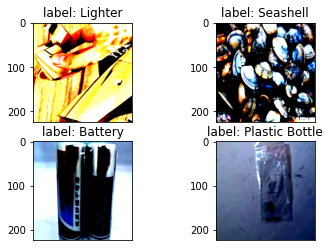

In [13]:
ds = create_dataset(dataset_path=config.dataset_path, config=config, training=False)
print(ds.get_dataset_size())
data = ds.create_dict_iterator(output_numpy=True)._get_next()
print("noob")
images = data['image']
labels = data['label']

for i in range(1, 5):
    plt.subplot(2, 2, i)
    plt.imshow(np.transpose(images[i], (1,2,0)))
    plt.title('label: %s' % class_en[labels[i]])
    plt.xticks([])
plt.show()

## 2. Training Strategy

You could use static the learning rate for training, e.g.0.01. But usually, as the training step increases, model training converges, the learning rate should be smaller. So usually decaying learning rate is used. The typical learning rate strategy includes:

- polynomial decay/square decay;
- cosine decay;
- exponential decay;
- stage decay.

Here, we use cosine decay.

In [14]:
def cosine_decay(total_steps, lr_init=0.0, lr_end=0.0, lr_max=0.1, warmup_steps=0):
    """
    Applies cosine decay to generate learning rate array.

    Args:
       total_steps(int): all steps in training.
       lr_init(float): init learning rate.
       lr_end(float): end learning rate
       lr_max(float): max learning rate.
       warmup_steps(int): all steps in warmup epochs.

    Returns:
       list, learning rate array.
    """
    lr_init, lr_end, lr_max = float(lr_init), float(lr_end), float(lr_max)
    decay_steps = total_steps - warmup_steps
    lr_all_steps = []
    inc_per_step = (lr_max - lr_init) / warmup_steps if warmup_steps else 0
    for i in range(total_steps):
        if i < warmup_steps:
            lr = lr_init + inc_per_step * (i + 1)
        else:
            cosine_decay = 0.5 * (1 + math.cos(math.pi * (i - warmup_steps) / decay_steps))
            lr = (lr_max - lr_end) * cosine_decay + lr_end
        lr_all_steps.append(lr)

    return lr_all_steps

## 3. Model Training

In the model training process, you could add checkpoint to save model parameters, so can continue the training process if interupted. Usually used in following cases: 

- Inference after training
    - Save trained model after training finished, for inference purpose
    - In the training process, save multiple checkpoints, and select the one with highest accuracy
- Model Retraining
    - If the training takes long, save intermedia checkpoints in case of interruption
    - Fine-tuning

Here, we load the MobileNetV2 model pretrained on ImageNet and then Fine-tuning，**Only train the last FC layer**，and save the Checkpoints

In [15]:
def switch_precision(net, data_type):
    if context.get_context('device_target') == "Ascend":
        net.to_float(data_type)
        for _, cell in net.cells_and_names():
            if isinstance(cell, nn.Dense):
                cell.to_float(ms.float32)

### 3.1 Partial Training

> **Note：** Only choose either 3.1 or 3.2 to run

Inference on the dataset with the layers that we want to freeze (no training), and save their output featuremap, which will be used to train the last FC layer as input

#### 3.1.1 Extract featuremap


In [16]:
def extract_features(net, dataset_path, config):
    features_folder = dataset_path + '_features'
    if not os.path.exists(features_folder):
        os.makedirs(features_folder)
    dataset = create_dataset(dataset_path=dataset_path, config=config)
    step_size = dataset.get_dataset_size()
    if step_size == 0:
        raise ValueError("The step_size of dataset is zero. Check if the images count of train dataset is more \
            than batch_size in config.py")

    for i, data in enumerate(dataset.create_dict_iterator(output_numpy=True)):
        features_path = os.path.join(features_folder, f"feature_{i}.npy")
        label_path = os.path.join(features_folder, f"label_{i}.npy")
        if not os.path.exists(features_path) or not os.path.exists(label_path):
            image = data["image"]
            label = data["label"]
            features = net(Tensor(image))
            np.save(features_path, features.asnumpy())
            np.save(label_path, label)
        print(f"Complete the batch {i+1}/{step_size}")
    return

backbone = MobileNetV2Backbone() #last_channel=config.backbone_out_channels
load_checkpoint(config.pretrained_ckpt, backbone)
extract_features(backbone, config.dataset_path, config)

[WARNING] ME(145753:281473268531616,MainProcess):2023-02-26-22:39:09.165.552 [mindspore/common/_decorator.py:33] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(145753:281473268531616,MainProcess):2023-02-26-22:39:09.205.832 [mindspore/common/_decorator.py:33] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(145753:281473268531616,MainProcess):2023-02-26-22:39:09.243.576 [mindspore/common/_decorator.py:33] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(145753:281473268531616,MainProcess):2023-02-26-22:39:09.278.269 [mindspore/common/_decorator.py:33] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(145753:281473268531616,MainProcess):2023-02-26-22:39:09.312.585 [mindspore/common/_decorator.py:33] 'TensorAdd' is deprecat

Complete the batch 1/40
Complete the batch 2/40
Complete the batch 3/40
Complete the batch 4/40
Complete the batch 5/40
Complete the batch 6/40
Complete the batch 7/40
Complete the batch 8/40
Complete the batch 9/40
Complete the batch 10/40
Complete the batch 11/40
Complete the batch 12/40
Complete the batch 13/40
Complete the batch 14/40
Complete the batch 15/40
Complete the batch 16/40
Complete the batch 17/40
Complete the batch 18/40
Complete the batch 19/40
Complete the batch 20/40
Complete the batch 21/40
Complete the batch 22/40
Complete the batch 23/40
Complete the batch 24/40
Complete the batch 25/40
Complete the batch 26/40
Complete the batch 27/40
Complete the batch 28/40
Complete the batch 29/40
Complete the batch 30/40
Complete the batch 31/40
Complete the batch 32/40
Complete the batch 33/40
Complete the batch 34/40
Complete the batch 35/40
Complete the batch 36/40
Complete the batch 37/40
Complete the batch 38/40
Complete the batch 39/40
Complete the batch 40/40


# Soroush Note
Here we are using transfer learning and using a feature extractor. in section 3.2 we are training the entire network.
I should point out that after running this code these folders were created:

1. ascend
2. data_en_features
3. rank_0


#### 3.1.2 Train Head


In [17]:
def train_head():
    train_dataset = create_dataset(dataset_path=config.dataset_path, config=config)
    eval_dataset = create_dataset(dataset_path=config.dataset_path, config=config)
    step_size = train_dataset.get_dataset_size()
    
    backbone = MobileNetV2Backbone()
    # Freeze parameters of backbone. You can comment these two lines.
    for param in backbone.get_parameters():
       param.requires_grad = False
    load_checkpoint(config.pretrained_ckpt, backbone)

    head = MobileNetV2Head(input_channel=backbone.out_channels, num_classes=config.num_classes)
    network = mobilenet_v2(backbone, head)
    #switch_precision(network, ms.float16)
    
    # define loss, optimizer, and model
    loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
    lrs = cosine_decay(config.epochs * step_size, lr_max=config.lr_max, warmup_steps=0)
    opt = nn.Momentum(head.trainable_params(), lrs, config.momentum, config.weight_decay)
    net = nn.WithLossCell(head, loss)
    train_step = nn.TrainOneStepCell(net, opt)
    train_step.set_train()
    
    # train
    history = list()
    features_path = config.dataset_path + '_features'
    idx_list = list(range(step_size))
    for epoch in range(config.epochs):
        random.shuffle(idx_list)
        epoch_start = time.time()
        losses = []
        for j in idx_list:
            feature = Tensor(np.load(os.path.join(features_path, f"feature_{j}.npy")))
            label = Tensor(np.load(os.path.join(features_path, f"label_{j}.npy")))
            losses.append(train_step(feature, label).asnumpy())
        epoch_seconds = (time.time() - epoch_start)
        epoch_loss = np.mean(np.array(losses))
        
        history.append(epoch_loss)
        print("epoch: {}, time cost: {}, avg loss: {}".format(epoch + 1, epoch_seconds, epoch_loss))
        if (epoch + 1) % config.save_ckpt_epochs == 0:
            save_checkpoint(network, os.path.join(config.save_ckpt_path, f"mobilenetv2-{epoch+1}.ckpt"))
    
    # evaluate
    eval_model = Model(network, loss, metrics={'acc', 'loss'})
    acc = eval_model.eval(eval_dataset)
    print(acc)
    
    return history

[WARNING] ME(145753:281473268531616,MainProcess):2023-02-26-22:39:25.192.549 [mindspore/common/_decorator.py:33] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(145753:281473268531616,MainProcess):2023-02-26-22:39:25.230.202 [mindspore/common/_decorator.py:33] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(145753:281473268531616,MainProcess):2023-02-26-22:39:25.278.440 [mindspore/common/_decorator.py:33] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(145753:281473268531616,MainProcess):2023-02-26-22:39:25.317.882 [mindspore/common/_decorator.py:33] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(145753:281473268531616,MainProcess):2023-02-26-22:39:25.355.721 [mindspore/common/_decorator.py:33] 'TensorAdd' is deprecat

epoch: 1, time cost: 17.82689666748047, avg loss: 1.1597609519958496
epoch: 2, time cost: 1.409881353378296, avg loss: 0.3269261121749878
epoch: 3, time cost: 1.0584471225738525, avg loss: 0.18703912198543549
epoch: 4, time cost: 0.8494408130645752, avg loss: 0.10365275293588638
epoch: 5, time cost: 1.0643246173858643, avg loss: 0.08110307157039642
epoch: 6, time cost: 1.232433557510376, avg loss: 0.06297467648983002
epoch: 7, time cost: 1.1565189361572266, avg loss: 0.055956847965717316
epoch: 8, time cost: 1.0568509101867676, avg loss: 0.05229562520980835
epoch: 9, time cost: 1.256248950958252, avg loss: 0.050349265336990356
epoch: 10, time cost: 1.0997943878173828, avg loss: 0.049569401890039444


[WARNING] SESSION(145753,fffdfcfe51f0,python):2023-02-26-22:40:01.645.868 [mindspore/ccsrc/backend/session/ascend_session.cc:1806] SelectKernel] There are 52 node/nodes used reduce precision to selected the kernel!
[WARNING] KERNEL(145753,fffdfcfe51f0,python):2023-02-26-22:40:03.876.102 [mindspore/ccsrc/backend/kernel_compiler/tbe/tbe_kernel_select/tbe_kernel_select.cc:210] FilterInVaildKernelInfo] Tbe kernel info list is empty, all valid kernel info was filtered out. Check the input shape, attrs or other value of node : Default/network-WithEvalCell/_network-MobileNetV2Combine/backbone-MobileNetV2Backbone/features-SequentialCell/15-InvertedResidual/conv-SequentialCell/1-ConvBNReLU/features-SequentialCell/0-Conv2d/TransposeNOD-op1073
[WARNING] KERNEL(145753,fffdfcfe51f0,python):2023-02-26-22:40:03.914.319 [mindspore/ccsrc/backend/kernel_compiler/tbe/tbe_kernel_select/tbe_kernel_select.cc:210] FilterInVaildKernelInfo] Tbe kernel info list is empty, all valid kernel info was filtered out.

{'loss': 0.2587565815076232, 'acc': 0.930859375}


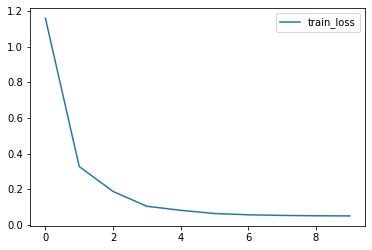

Chosen checkpoint is mobilenetv2-10.ckpt


In [19]:
if os.path.exists(config.save_ckpt_path):
    shutil.rmtree(config.save_ckpt_path)
os.makedirs(config.save_ckpt_path)

history = train_head()

plt.plot(history, label='train_loss')
plt.legend()
plt.show()

CKPT = f'mobilenetv2-{config.epochs}.ckpt'
print("Chosen checkpoint is", CKPT)

# Soroush Note
after running the code, folder ckpt was made

In [20]:
print("done")

done


### 3.2 Train the Whole Network

The freezed layers will also run in the forward pass，but will not learn (learning rate set as 0, weight will not be updated).

#### 3.2.1 Traing and Validate

With a complex network, it usually takes hundreds of epochs to train. It is hard to tell when you will get the desired accruayc, so usually you will save checkpoints once in a while and evaluate its accuracy, and choose the best one when the whole training finished

- Define call-back function 'EvalCallback'，to evaluate while training
- Define the network and run
- Draw accruacy curve under different epochs, and select the checkpoint with best accuracy

Generalization capability of a DL network is important. But its training tends to over-fit. During the training process, we can tell over-fitting is happening when its accruacy gets increased in trainig dataset, but decreased in validation dataset. In this case, we could do 'early-stopping', i.e., stop training if the validate accuracy stops increasing in 5 epochs. 

In [21]:
class EvalCallback(Callback):
    def __init__(self, model, eval_dataset, history, eval_epochs=1):
        self.model = model
        self.eval_dataset = eval_dataset
        self.eval_epochs = eval_epochs
        self.history = history
        self.acc_max = 0
        # early stopping, accuracy stops increasing in 5 epochs
        self.count_max = 5
        self.count = 0
    
    def epoch_begin(self, run_context):
        self.losses = []
    
    def step_end(self, run_context):
        cb_param = run_context.original_args()
        loss = cb_param.net_outputs
        self.losses.append(loss.asnumpy())
    
    def epoch_end(self, run_context):
        cb_param = run_context.original_args()
        cur_epoch = cb_param.cur_epoch_num
        train_loss = np.mean(self.losses)
        
        if cur_epoch % self.eval_epochs == 0:
            metric = self.model.eval(self.eval_dataset, dataset_sink_mode=False)
            self.history["epoch"].append(cur_epoch)
            self.history["eval_acc"].append(metric["acc"])
            self.history["eval_loss"].append(metric["loss"])
            self.history["train_loss"].append(train_loss)
            if self.acc_max < metric["acc"]:
                self.count = 0
                self.acc_max = metric["acc"]
            else:
                self.count += 1
                if self.count == self.count_max:
                    run_context.request_stop()
            print("epoch: %d, train_loss: %f, eval_loss: %f, eval_acc: %f" %(cur_epoch, train_loss, metric["loss"], metric["acc"]))

#### 3.2.2. Training on Original Dataset

In [22]:
from mindspore.train.loss_scale_manager import FixedLossScaleManager
LOSS_SCALE = 1024
def train():
    train_dataset = create_dataset(dataset_path=config.dataset_path, config=config)
    eval_dataset = create_dataset(dataset_path=config.dataset_path, config=config)
    step_size = train_dataset.get_dataset_size()
    
    backbone = MobileNetV2Backbone() #last_channel=config.backbone_out_channels
    # Freeze parameters of backbone. You can comment these two lines.
    for param in backbone.get_parameters():
       param.requires_grad = False
    # load parameters from pretrained model
    load_checkpoint(config.pretrained_ckpt, backbone)

    # head = MobileNetV2Head(num_classes=config.num_classes, last_channel=config.backbone_out_channels)
    head = MobileNetV2Head(input_channel=backbone.out_channels, num_classes=config.num_classes)
    network = mobilenet_v2(backbone, head)

    # define loss, optimizer, and model
    loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
    loss_scale = FixedLossScaleManager(LOSS_SCALE, drop_overflow_update=False)
    lrs = cosine_decay(config.epochs * step_size, lr_max=config.lr_max)
    opt = nn.Momentum(network.trainable_params(), lrs, config.momentum, config.weight_decay, loss_scale=LOSS_SCALE)
    model = Model(network, loss, opt, loss_scale_manager=loss_scale, metrics={'acc', 'loss'})

    history = {'epoch': [], 'train_loss': [], 'eval_loss': [], 'eval_acc': []}
    eval_cb = EvalCallback(model, eval_dataset, history)
    cb = [eval_cb]
    ckpt_cfg = CheckpointConfig(save_checkpoint_steps=config.save_ckpt_epochs * step_size, keep_checkpoint_max=config.epochs)
    ckpt_cb = ModelCheckpoint(prefix="mobilenetv2", directory=config.save_ckpt_path, config=ckpt_cfg)
    cb.append(ckpt_cb)
    model.train(15, train_dataset, callbacks=cb, dataset_sink_mode=False)
    
    return history

Draw accruacy curve under different epochs, and select the checkpoint with best accuracy

[WARNING] ME(145753:281473268531616,MainProcess):2023-02-26-22:40:22.732.370 [mindspore/common/_decorator.py:33] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(145753:281473268531616,MainProcess):2023-02-26-22:40:22.774.195 [mindspore/common/_decorator.py:33] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(145753:281473268531616,MainProcess):2023-02-26-22:40:22.816.208 [mindspore/common/_decorator.py:33] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(145753:281473268531616,MainProcess):2023-02-26-22:40:22.855.143 [mindspore/common/_decorator.py:33] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(145753:281473268531616,MainProcess):2023-02-26-22:40:22.895.943 [mindspore/common/_decorator.py:33] 'TensorAdd' is deprecat

epoch: 1, train_loss: 1.472878, eval_loss: 0.603598, eval_acc: 0.820312
epoch: 2, train_loss: 0.653814, eval_loss: 0.496359, eval_acc: 0.855859
epoch: 3, train_loss: 0.510012, eval_loss: 0.475901, eval_acc: 0.861328
epoch: 4, train_loss: 0.466544, eval_loss: 0.402654, eval_acc: 0.880078
epoch: 5, train_loss: 0.415677, eval_loss: 0.334792, eval_acc: 0.910156
epoch: 6, train_loss: 0.389445, eval_loss: 0.307962, eval_acc: 0.918359
epoch: 7, train_loss: 0.371341, eval_loss: 0.301674, eval_acc: 0.924219
epoch: 8, train_loss: 0.330095, eval_loss: 0.294413, eval_acc: 0.919141
epoch: 9, train_loss: 0.362163, eval_loss: 0.288576, eval_acc: 0.923828
epoch: 10, train_loss: 0.376955, eval_loss: 0.277859, eval_acc: 0.926953
epoch: 11, train_loss: 0.326532, eval_loss: 0.288898, eval_acc: 0.923047
epoch: 12, train_loss: 0.340352, eval_loss: 0.309259, eval_acc: 0.915625
epoch: 13, train_loss: 0.354801, eval_loss: 0.288785, eval_acc: 0.919531
epoch: 14, train_loss: 0.365854, eval_loss: 0.290794, eval_a

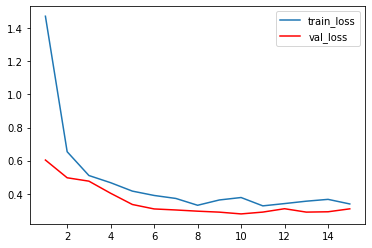

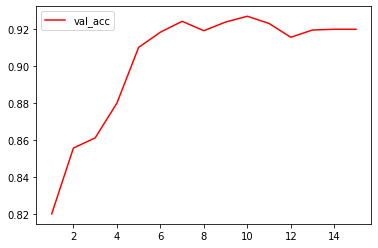

Chosen checkpoint is mobilenetv2-10_40.ckpt


In [23]:
if os.path.exists(config.save_ckpt_path):
    shutil.rmtree(config.save_ckpt_path)

history = train()

plt.plot(history['epoch'], history['train_loss'], label='train_loss')
plt.plot(history['epoch'], history['eval_loss'], 'r', label='val_loss')
plt.legend()
plt.show()

plt.plot(history['epoch'], history['eval_acc'], 'r', label = 'val_acc')
plt.legend()
plt.show()

CKPT = 'mobilenetv2-%d_40.ckpt' % (np.argmax(history['eval_acc']) + 1) # Choose best Checkpoint, modify the value '40' according to dataset and batchsize.
print("Chosen checkpoint is", CKPT)

In [24]:
print("A")

A


## 4. Model Inference

Load Checkpoint to infer.

> When you 'load_checkpoint'，you need to use the 'forward-only' network without the backward pass

In [25]:
def image_process(image):
    """Precess one image per time.
    
    Args:
        image: shape (H, W, C)
    """
    mean=[0.485*255, 0.456*255, 0.406*255]
    std=[0.229*255, 0.224*255, 0.225*255]
    image = (np.array(image) - mean) / std
    image = image.transpose((2,0,1))
    img_tensor = Tensor(np.array([image], np.float32))
    return img_tensor

def infer_one(network, image_path):
    image = Image.open(image_path).resize((config.image_height, config.image_width))
    logits = network(image_process(image))
    pred = np.argmax(logits.asnumpy(), axis=1)[0]
    print(image_path, class_en[pred])

def infer():
    backbone = MobileNetV2Backbone(last_channel=config.backbone_out_channels)
    head = MobileNetV2Head(input_channel=backbone.out_channels, num_classes=config.num_classes)
    network = mobilenet_v2(backbone, head)
    print(os.path.join(config.save_ckpt_path, CKPT))
    load_checkpoint(os.path.join(config.save_ckpt_path, CKPT), network)
    for i in range(91, 100):
        infer_one(network, f'data_en/test/Cardboard/000{i}.jpg')

In [26]:
infer()

[WARNING] ME(145753:281473268531616,MainProcess):2023-02-26-22:42:58.207.116 [mindspore/common/_decorator.py:33] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(145753:281473268531616,MainProcess):2023-02-26-22:42:58.246.371 [mindspore/common/_decorator.py:33] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(145753:281473268531616,MainProcess):2023-02-26-22:42:58.283.870 [mindspore/common/_decorator.py:33] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(145753:281473268531616,MainProcess):2023-02-26-22:42:58.321.622 [mindspore/common/_decorator.py:33] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(145753:281473268531616,MainProcess):2023-02-26-22:42:58.361.522 [mindspore/common/_decorator.py:33] 'TensorAdd' is deprecat

./ckpt/mobilenetv2-10_40.ckpt


[WARNING] SESSION(145753,fffdfcfe51f0,python):2023-02-26-22:43:03.729.534 [mindspore/ccsrc/backend/session/ascend_session.cc:1806] SelectKernel] There are 52 node/nodes used reduce precision to selected the kernel!
[WARNING] KERNEL(145753,fffdfcfe51f0,python):2023-02-26-22:43:05.956.469 [mindspore/ccsrc/backend/kernel_compiler/tbe/tbe_kernel_select/tbe_kernel_select.cc:210] FilterInVaildKernelInfo] Tbe kernel info list is empty, all valid kernel info was filtered out. Check the input shape, attrs or other value of node : Default/backbone-MobileNetV2Backbone/features-SequentialCell/15-InvertedResidual/conv-SequentialCell/1-ConvBNReLU/features-SequentialCell/0-Conv2d/TransposeNOD-op5303
[WARNING] KERNEL(145753,fffdfcfe51f0,python):2023-02-26-22:43:05.989.289 [mindspore/ccsrc/backend/kernel_compiler/tbe/tbe_kernel_select/tbe_kernel_select.cc:210] FilterInVaildKernelInfo] Tbe kernel info list is empty, all valid kernel info was filtered out. Check the input shape, attrs or other value of n

data_en/test/Cardboard/00091.jpg Cardboard
data_en/test/Cardboard/00092.jpg Cardboard
data_en/test/Cardboard/00093.jpg Cardboard
data_en/test/Cardboard/00094.jpg Cardboard
data_en/test/Cardboard/00095.jpg Cardboard
data_en/test/Cardboard/00096.jpg Cardboard
data_en/test/Cardboard/00097.jpg Cardboard
data_en/test/Cardboard/00098.jpg Cardboard
data_en/test/Cardboard/00099.jpg Cardboard


In [27]:
print("Holla")

Holla


## 5. Export AIR model file

Export AIR model file to be used for model conversion and inference on Atals 200 Dk

In [28]:
backbone = MobileNetV2Backbone(last_channel=config.backbone_out_channels)
head = MobileNetV2Head(input_channel=backbone.out_channels, num_classes=config.num_classes)
network = mobilenet_v2(backbone, head)
load_checkpoint(os.path.join(config.save_ckpt_path, CKPT), network)

input = np.random.uniform(0.0, 1.0, size=[1, 3, 224, 224]).astype(np.float32)
export(network, Tensor(input), file_name='mobilenetv2.air', file_format='AIR') # MindSpore 1.0
# export(network, Tensor(input), file_name='mobilenetv2.pb', file_format='GEIR') # MindSpore 0.5
# export(network, Tensor(input), file_name='mobilenetv2.onnx', file_format='ONNX')

[WARNING] ME(145753:281473268531616,MainProcess):2023-02-26-22:43:20.994.854 [mindspore/common/_decorator.py:33] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(145753:281473268531616,MainProcess):2023-02-26-22:43:21.328.59 [mindspore/common/_decorator.py:33] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(145753:281473268531616,MainProcess):2023-02-26-22:43:21.689.94 [mindspore/common/_decorator.py:33] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(145753:281473268531616,MainProcess):2023-02-26-22:43:21.104.413 [mindspore/common/_decorator.py:33] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(145753:281473268531616,MainProcess):2023-02-26-22:43:21.140.066 [mindspore/common/_decorator.py:33] 'TensorAdd' is deprecated

In [29]:
print("hell")

hell


# Soroush
It created a file named mobilenetV2.air